In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.misc import face
import skimage.io as skio

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "viridis"

rng = np.random.default_rng(seed=0)

![Pycsou](https://matthieumeo.github.io/pycsou/html/_images/pycsou.png)
# A High Performance Computational Imaging Framework for Python

# Introduction to Computational Imaging

## Inverse Problems in a Nutshell

Most real-life imaging problems can be formulated as *linear inverse problems*: 

\begin{align} \text{Find  }\mathbf{\alpha}\in\mathbb{R}^N &\text{ from noisy measurements } \mathbf{y}\sim \mathbf{Y}\\ 
   &\text{ where } \mathbb{E}[\mathbf{Y}]=\mathbf{G}\mathbf{\alpha}\;
   \text{ and }\; \mathbf{G}:\mathbb{R}^N\to \mathbb{R}^L \text{ is a linear operator.} \end{align}
   
* The data vector  $\mathbf{y}$ is assumed to be the outcome of  a random vector $\mathbf{Y}=[Y_1,\ldots,Y_L]:\Omega\rightarrow \mathbb{R}^L$, fluctuating according to some noise distribution. The entries of $\mathbb{E}[\mathbf{Y}]=\tilde{\mathbf{y}}$ are called the *ideal/noiseless measurements*.
* The measurements are assumed *unbiased* and *linear*, i.e. $\mathbb{E}[\mathbf{Y}]=\mathbf{G}\mathbf{\alpha}$, where the *sensing/forward matrix* $\mathbf{G}$ models the imaging system.

### Example: Image Deblurring

![Deblurring](doc/images/deblurring.jpg)
*Image deblurring is a common example of inverse problem. In this case, measurements are the pixels of the original image $\alpha$ blurred by the Toeplitz sensing/forward operator $\mathbf{G}$.*

## Inverse Problems are Ill-Posed

To solve an inverse problem one could **naively** solve the linear problem: 

$$\mathbf{y}=\mathbf{G}\mathbf{\alpha}. \label{discrete_pb}\tag{1}$$


Unfortunately, such problems are in general **ill-posed**:

* **There may exist no solutions.** If $\mathbf{G}$ is not *surjective*, $\mathcal{R}(\mathbf{G})\subsetneq \mathbb{R}^L$. Then the noisy data vector $\mathbf{y}$ may not belong to $\mathcal{R}(\mathbf{G})$, hence making (1) *unfeasible*.

* **There may exist more than one solution.** If $\mathbf{G}$ is not *injective*, $\mathcal{N}(\mathbf{G})\neq \{\mathbf{0}\}$. Therefore, if $\mathbf{\alpha}^\star$ is a solution to (1), then $\mathbf{\alpha}^\star + \mathbf{\beta}$ is also a solution $\forall\mathbf{\beta}\in \mathcal{N}(\mathbf{G})$.  

* **Solutions may be numerically unstable.** If $\mathbf{G}$ is *surjective* for example, then $\mathbf{G}^\dagger=\mathbf{G}^T(\mathbf{G}\mathbf{G}^T)^{-1}$ is a right-inverse of $\mathbf{G}$ and $\mathbf{\alpha}^\star(\mathbf{y})=\mathbf{G}^\dagger \mathbf{y}$ is a solution to (1). We have then  
$$   \|\mathbf{\alpha}^\star(\mathbf{y})\|_2\leq \|\mathbf{G}\|_2\|(\mathbf{G}^T\mathbf{G})^{-1}\|_2\|\mathbf{y}\|_2=\underbrace{\frac{\sqrt{\lambda_{max}(\mathbf{G}^T\mathbf{G})}}{\lambda_{min}(\mathbf{G}^T\mathbf{G})}}_{\text{Can be very large!}}\|\mathbf{y}\|_2, \qquad \forall \mathbf{y}\in \mathbb{R}^L.$$
The reconstruction linear map $\mathbf{y}\mapsto \mathbf{\alpha}^\star(\mathbf{y})$ can hence be **virtually unbounded** making it *unstable*.

## Regularising Inverse Problems

As a remedy to their ill-posedness, linear inverse problems are commonly solved by means of handcrafted *Bayesian estimation problems*, confronting the physical evidence to the analyst’s a priori beliefs about the solution (e.g. smoothness, sparsity) via a *data-fidelity* and *regularisation term*, respectively: 

$$
   \tag{2}
   \min_{\mathbf{\alpha}\in\mathbb{R}^N} \,F(\mathbf{y}, \mathbf{G} \mathbf{\alpha})\quad+\quad \lambda\mathcal{R}(\mathbf{\alpha}).
  $$

* $F:\mathbb{R}^L\times \mathbb{R}^L\rightarrow \mathbb{R}_+\cup\{+\infty\}$ is the **loss functional**, measuring the discrepancy between the *observed* and *predicted* measurements $\mathbf{y}$ and $\mathbf{G}\mathbf{\alpha}$ respectively.

* $\mathcal{R}:\mathbb{R}^N\to \mathbb{R}_+\cup\{+\infty\}$ is a **penalty functional** favouring simple and well-behaved solutions (typically with a finite number of degrees of freedom). 


* $\lambda>0$ is a **penalty parameter** which controls the amount of regularisation by putting the regularisation functional and the cost functional on a similar scale.

### Choosing the Loss Functional

The loss functional can be chosen as the *negative log-likelihood* of the data $\mathbf{y}$:

$$ F(\mathbf{y},\mathbf{G} \mathbf{\alpha})=-\ell(\mathbf{\alpha}\vert\mathbf{y})=-\log p_{Y_1,\ldots,Y_L}\left(y_1,\ldots,y_L | \mathbf{\alpha}\right).$$

When the noise distribution is not fully known or the likelihood too complex, one can also use general $\ell_p$ cost functionals 

$$ F(\mathbf{y},\mathbf{G}\mathbf{\alpha})=\Vert\mathbf{y}-\mathbf{G}\mathbf{\alpha}\Vert_p^p=\sum_{i=1}^L\left\vert y_i-\sum_{n=1}^NG_{in} \alpha_n\right\vert^p,$$

where $p\in [1,+\infty]$ is typically chosen according to the tail behaviour of the noise distribution.


![lp_cost](doc/images/lp_cost.png)

### Choosing the Penalty

The penalty/prior functional is used to favour *physically-admissible solutions with simple behaviours*. It can be interpreted as implementing **Occam’s razor principle**.

In essence, this principle states that when two equally good explanations for a given phenomenon are available, one should **always favour the simplest**, i.e. the one that introduces the least explanatory variables.
What exactly is meant by "simple" solutions will depend on the specific application at hand. 

Common choices of regularisation strategies include: *Tikhonov regularisation* $\|\mathbf{D}\cdot\|_2^2$, *TV regularisation* $\|\mathbf{D}\cdot\|_1$, *elastic net regularisation* $\gamma\|\mathbf{D}_1\cdot\|_2^2 + (1-\gamma) \|\mathbf{D}_2\cdot\|_1$, *maximum entropy regularisation*, *plug-and-play*, *wavelet-based* etc...


## Proximal Algorithms
Most optimisation problems used to solve inverse problems in practice take the form: 

$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})} \tag{3}$$

where:
* $\mathcal{F}:\mathbb{R}^N\rightarrow \mathbb{R}$ is *convex* and *differentiable*, with $\beta$-*Lipschitz continuous* gradient.
* $\mathcal{G}:\mathbb{R}^N\rightarrow \mathbb{R}\cup\{+\infty\}$ and $\mathcal{H}:\mathbb{R}^M\rightarrow \mathbb{R}\cup\{+\infty\}$ are two *proper*, *lower semicontinuous* and *convex functions* with *simple proximal operators*.

* $\mathbf{K}:\mathbb{R}^N\rightarrow \mathbb{R}^M$ is a *linear operator*.

#### Example:
$$\min_{\mathbf{x}\in\mathbb{R}^N}\frac{1}{2}\left\|\mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2\quad+\quad\lambda_1 \|\mathbf{D}\mathbf{x}\|_1\quad+\quad\lambda_2 \|\mathbf{x}\|_1,$$

with $\mathbf{D}\in\mathbb{R}^{N\times N}$ and $\mathbf{G}\in\mathbb{R}^{L\times N}, \, \mathbf{y}\in\mathbb{R}^L, \lambda_1,\lambda_2>0.$ This problem can be written in the form 

$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$$

by choosing $\mathcal{F}(\mathbf{x})= \frac{1}{2}\left\|\mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2$, $\mathcal{G}(\mathbf{x})=\lambda_2\|\mathbf{x}\|_1$,
    $\mathcal{H}(\mathbf{x})=\lambda_1 \|\mathbf{x}\|_1$ and $\mathbf{K}=\mathbf{D}$.

Problems of the form (3) can be solved by means of iterative **proximal algorithms**:

* **Condat-Vu splitting or PD3O:** solves for problems of the form \
${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$
* **Chambolle-Pock splitting:** solves for problems of the form \
${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$
* **Douglas-Rachford splitting/ADMM:** solves for problems of the form \
${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{x})}$
* **Forward-Backward splitting/APGD:** solves for problems of the form \
$\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})$
* ... (and many more)
 
These are all **first-order algorithms**: they rely only on the gradient of $\mathcal{F}$, and/or the proximal operators of $\mathcal{G}, \mathcal{H}$, and/or matrix/vector multiplications with $\mathbf{K}$ and $\mathbf{K}^T$.

# `Pycsou`: A Computational Imaging Framework for Python

## The Adoptability and Reproducibility Crisis of Computational Imaging

Despite compelling advantages over traditional imaging, Bayesian image reconstruction often remains at the bare proof-of-concept stage. This can be explained by two main reasons: 

1. Effective deployment in production environments requires expert knowledge from both *imaging scientists* and *computer/data scientists*. This tight integration of *sensing* and *computation* is **difficult to achieve in practice**. 
2. The *monolithic architectures* of one-fits-all traditional imaging software pipelines are **fundamentally ill-suited** for Bayesian reconstruction techniques which require a lot of software flexibility to unveil their true power.

> For example, *TomoPy* gives access to no less than 14 different reconstruction algorithms from a *single* routine!

## The Need for a Computational Imaging Framework

To accelerate the path from research prototyping to production deployment, we need to rethink traditional imaging pipelines with an emphasis on **scalability** (for both CPUs and GPUs) and **modularity** (for high *customizability*).

This requires transitioning from **monolithic architectures to microservice ones** with highly *maintainable*, *testable*, *optimised*, *loosely coupled*, *hardware-agnostic* and *universal* software components.

While challenging, such a redesign is actually made possible by the *universality of the mathematical ingredients* from which Bayesian optimisation problems are typically built.

## The ``Pycsou`` Framework

[Pycsou](https://github.com/matthieumeo/pycsou) is an *open-source computational imaging software framework* for Python 3 with native support for *hardware acceleration* and *distributed computing*. The latter adopts a modular and interoperable *microservice architecture* providing **highly optimised and scalable** general-purpose computational imaging functionalities and tools, easy to **reuse and share across imaging modalities**. 

These include notably:
* a rich collection of common sensing operators and cost/penalty functionals, which can easily be combined via an **advanced operator algebra logic**,
* a complete base class hierarchy for implementing new, custom operators, 
* a comprehensive algorithmic suite featuring *generic* and *plug-and-play* state-of-the-art proximal methods,
* a *test suite* performing extensive **logical and functional** testing of Pycsou components.   

### High Performance Computing Features

To achieve **excellent performance and scalability**, Pycsou leverages at its core a number of *high-performance computing (HPC)* tools from the PyData stack:
* Pycsou offers a convenient **precision context manager** for changing locally the compute precision.
* Compute-critical components of the framework are **just-in-time compiled** by ``Numba``.
* Pycsou's operators are all **vectorised** and can process efficiently *stacks of inputs at once*. 
* Pycsou's code base is **module-agnostic**: a zero-copy dispatch mechanism redirects routine calls to NumPy, CuPy, Dask (or any NumPy-compliant library) based on the type of array being processed. 

> **Native support for hardware acceleration and distributed computing with a single, easy to maintain, test and read Python codebase!**

As an example, consider the following code snippet, defining the median operator:


```python
import pycsou.abc as pyca
import pycsou.runtime as pycrt
import pycsou.util as pycu

class Median(pyca.Map):
    def __init__(self):
        super(Median, self).__init__(shape=(1, None))  # The Median operator is domain-agnostic.

    @pycrt.enforce_precision(i='arr', o=True)  # Enforce input/output precision.
    def apply(self, arr: NDArray) -> NDArray:
        xp = pycu.get_array_module(arr)  # Find the array module for the provided input.
        return xp.median(arr, axis=-1, keepdims=True)  # The median function is applied to the last axis.
                                                       # The returned array has the same dimensions as the input thanks to the keyword keepdims=True.
```

This operator can then be fed various arrays as inputs:

```python
import pycsou.util.deps as pycd
m = Median()
for xp in pycd.supported_array_modules():
    out = m.apply(xp.arange(26).reshape(2, 13))  # Applies the operator in turn on a various array types.
```

If called from within the context manager Precision, the decorated apply method will automatically coerce the input/output to the user-specified precision:

```python
with pycu.Precision(pycu.Width.SINGLE):
    out = m.apply(np.arange(26).reshape(2, 13))  # Single precision is used for the computation
```

## Comparison with Competing Computational Imaging Frameworks
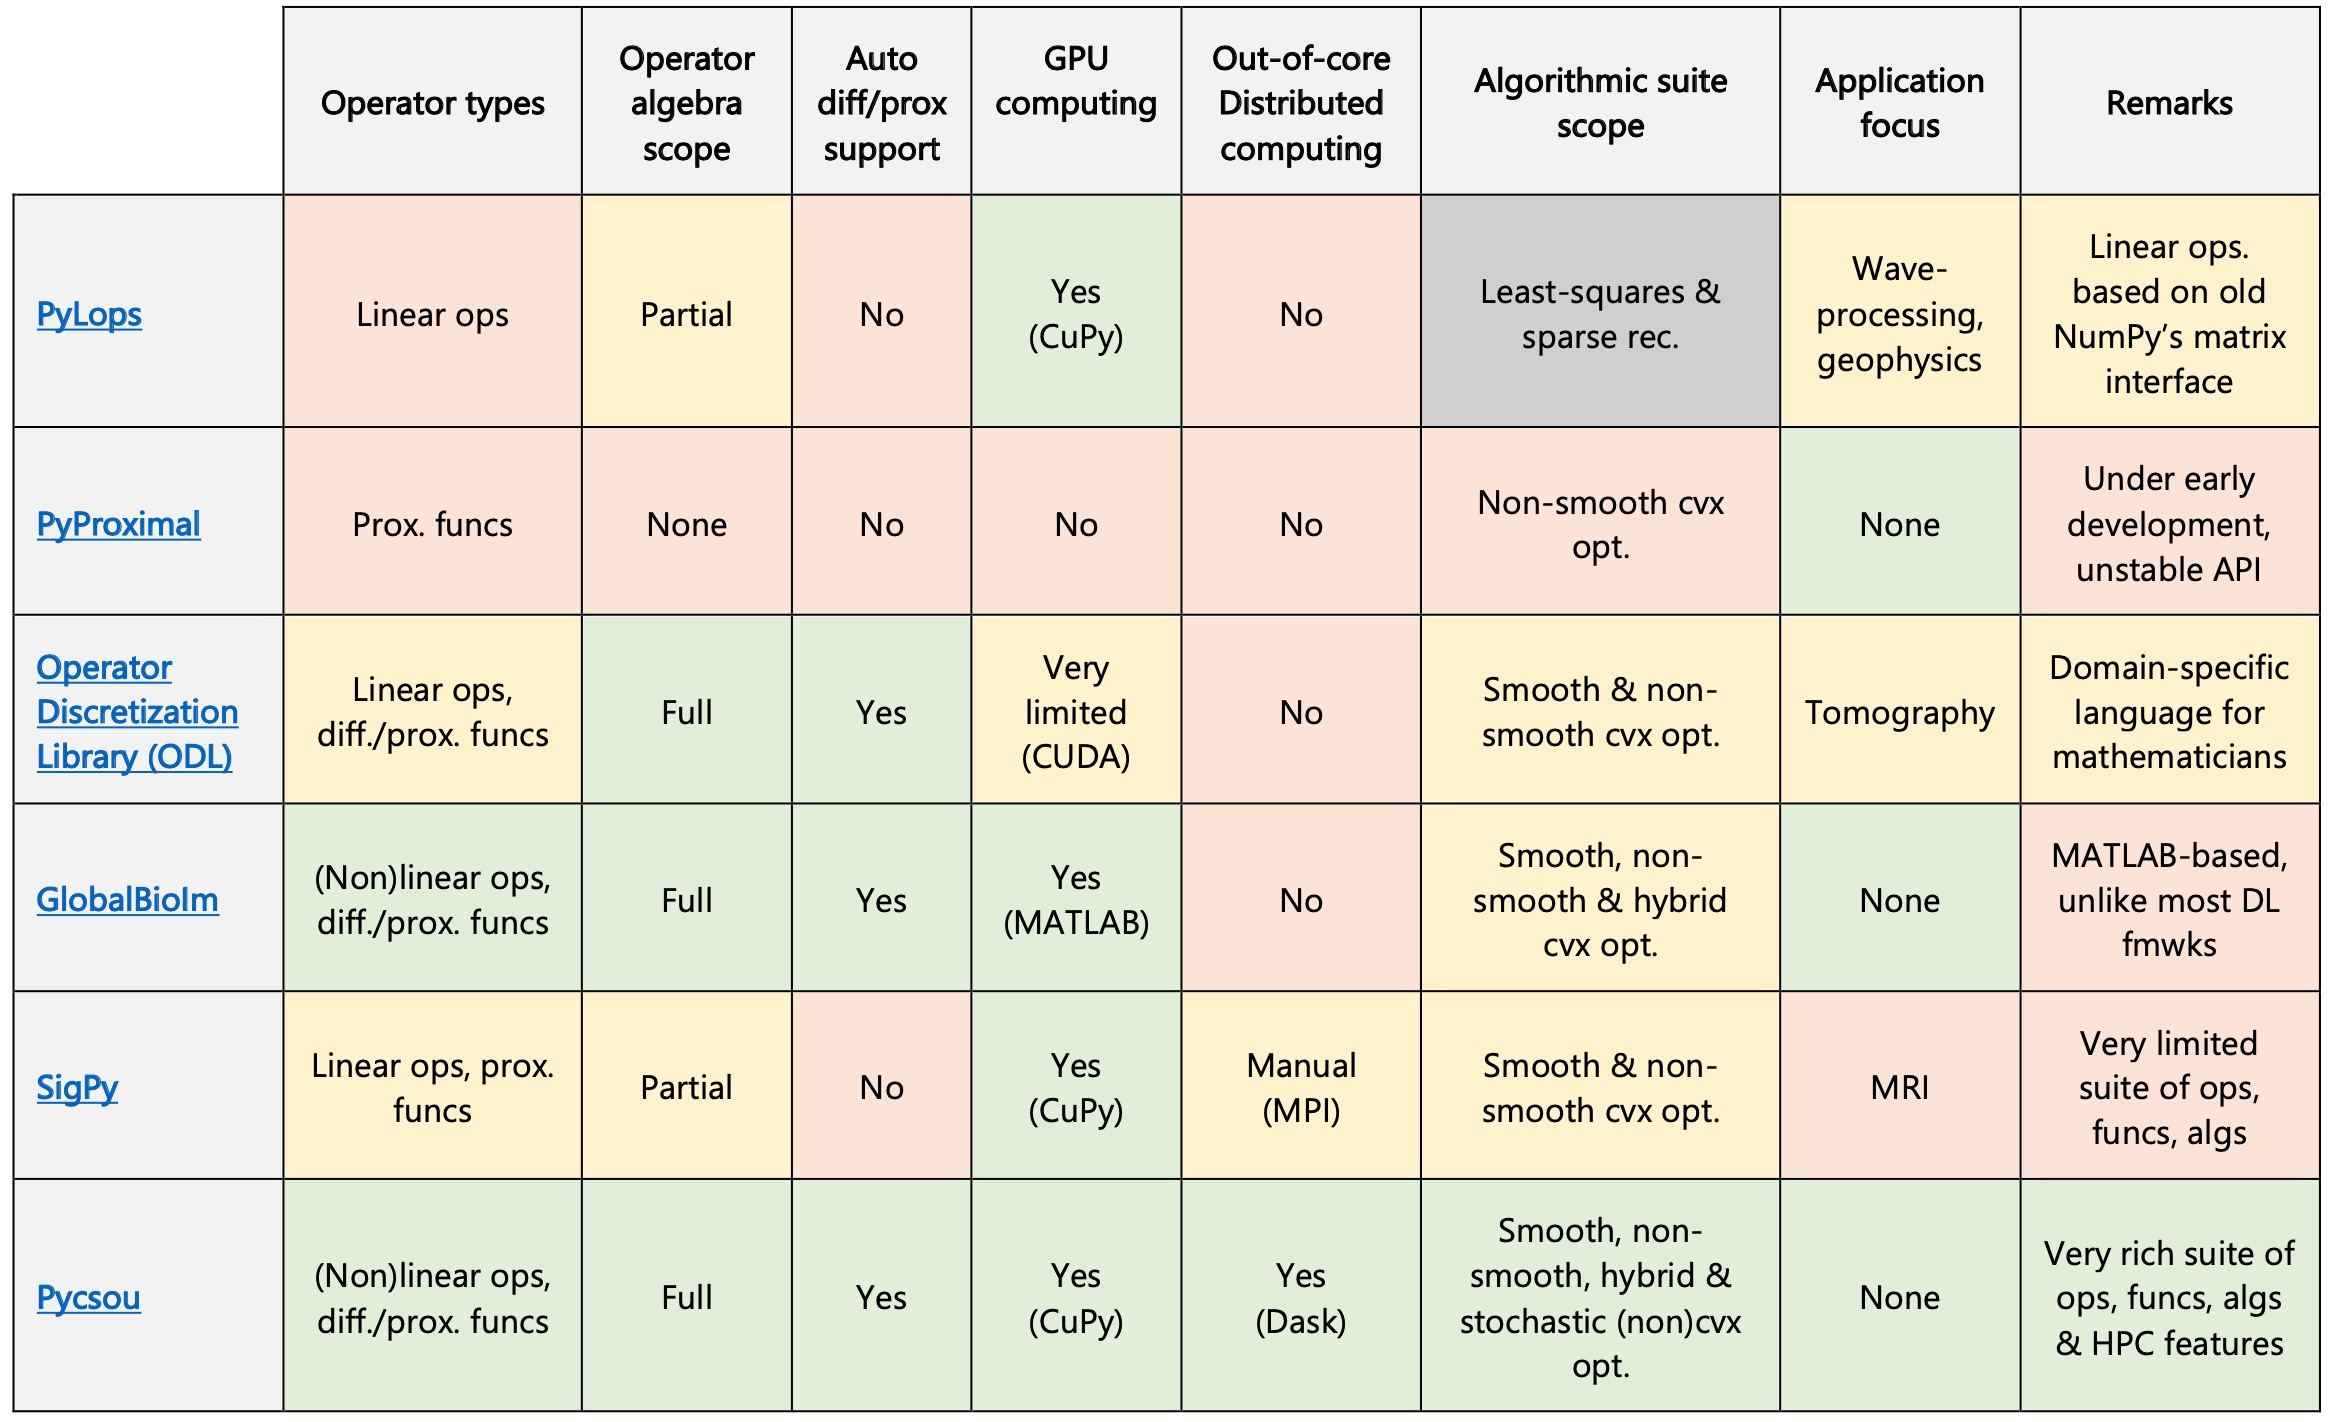

## Pycsou's Abstract Base Class Hierarchy

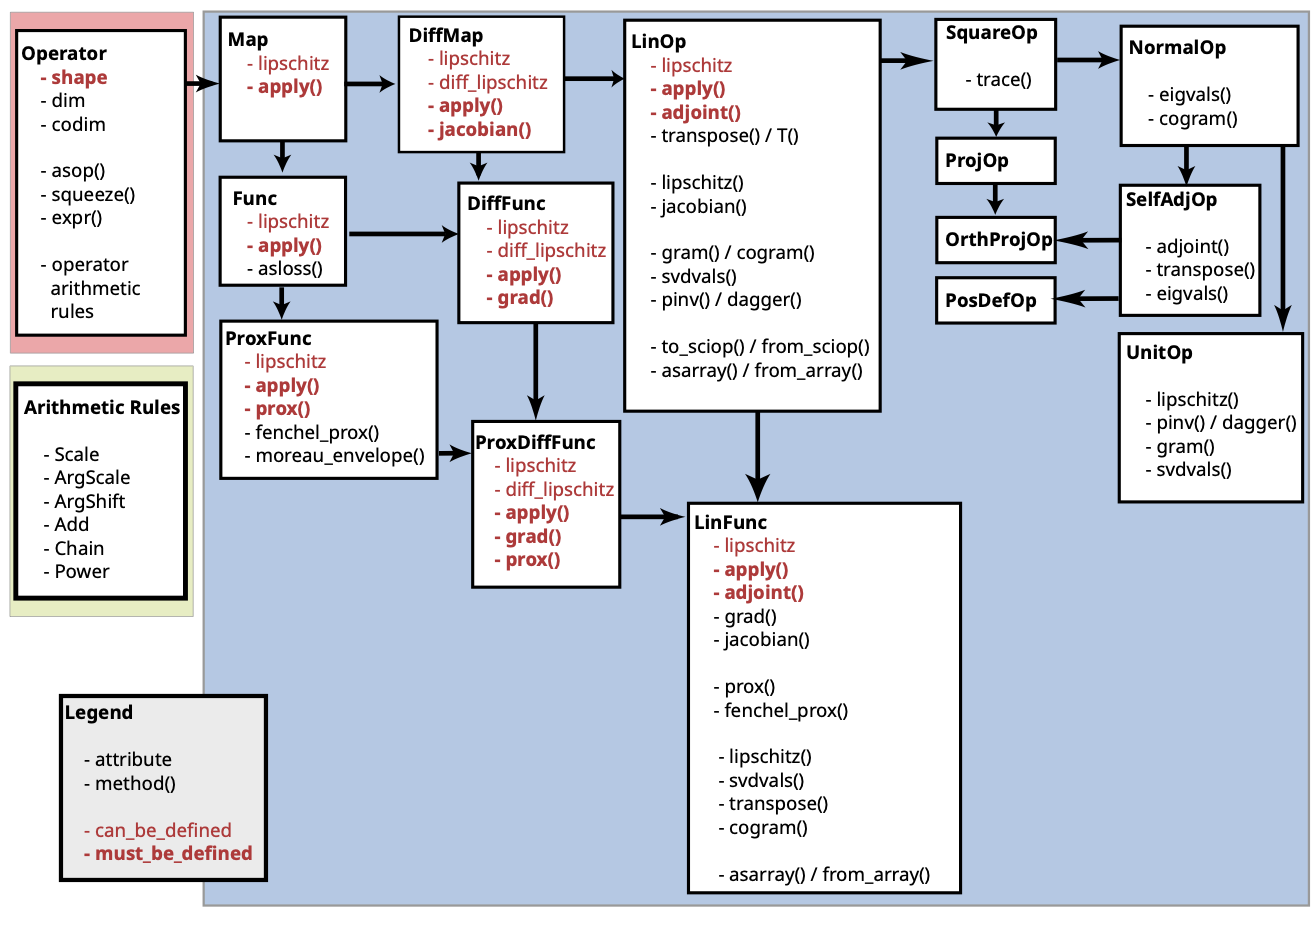

# Demo: Image Reconstruction by Deconvolution, Denoising and Fusion

### Ground Truth

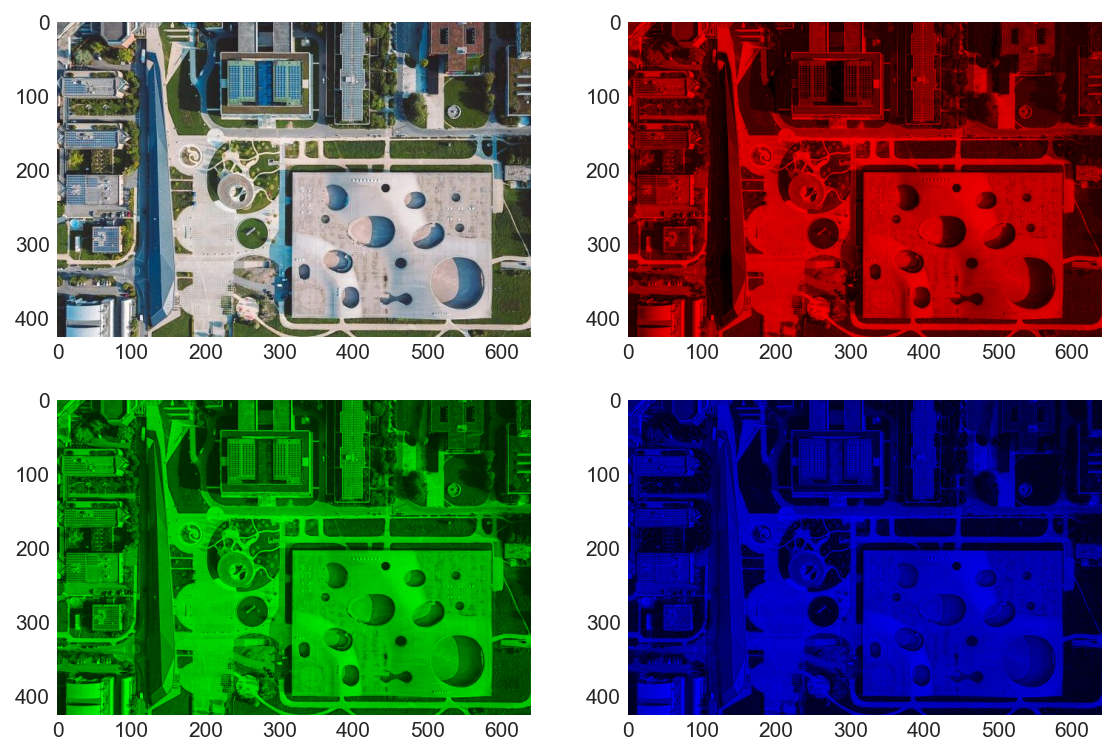

In [3]:
image = skio.imread("doc/images/image.jpg", as_gray=False).astype(np.float64)/255 # Load input image
image = np.moveaxis(image, -1, 0)

def monochromatic(im, chan=0):
    out = im.copy()
    mask = np.ones(im.shape, dtype=bool)
    mask[chan] = False
    out[mask] = 0
    return out

def imshow(im, rgb=True):
    if im.ndim > 2 and rgb:
        plt.subplot(2,2,1)
        plt.imshow(np.moveaxis(im, 0, -1))
        plt.subplot(2,2,2)
        plt.imshow(np.moveaxis(monochromatic(im, 0), 0, -1))
        plt.subplot(2,2,3)
        plt.imshow(np.moveaxis(monochromatic(im, 1), 0, -1))
        plt.subplot(2,2,4)
        plt.imshow(np.moveaxis(monochromatic(im, 2), 0, -1))
    else:
        plt.imshow(np.moveaxis(im, 0, -1))

imshow(image)

### Lensed photography

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


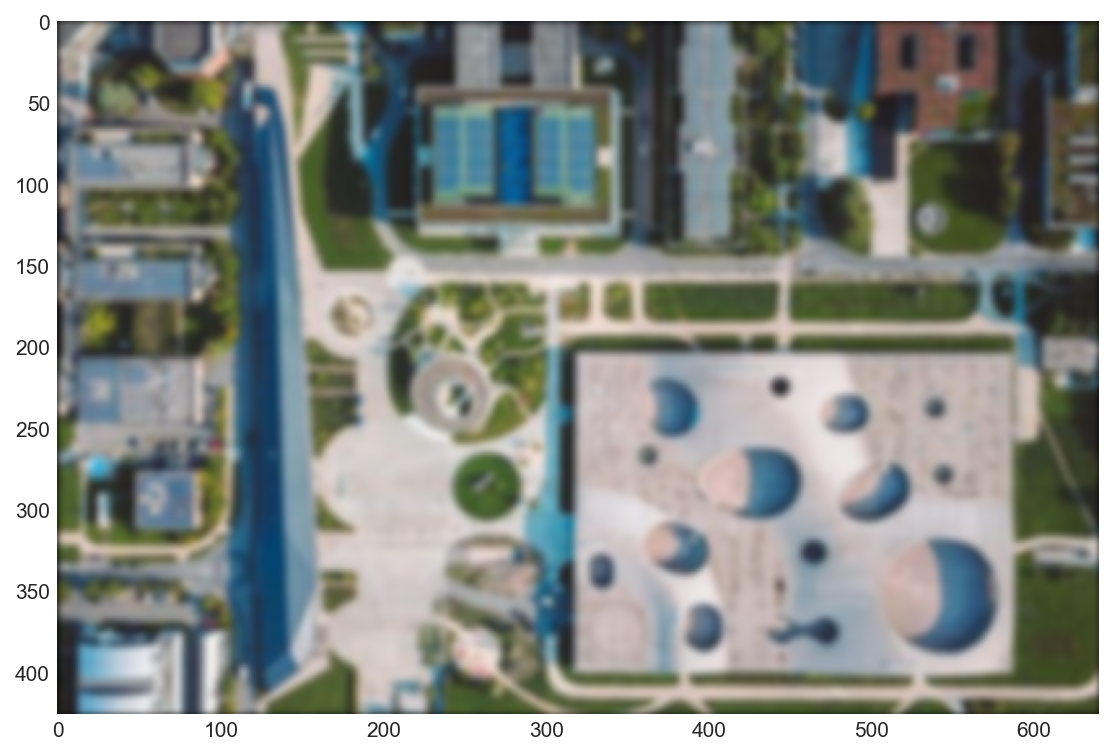

In [4]:
import pycsou.operator.linop as pycl
import pycsou.abc as pyca
import scipy.signal as ss

# Lens 
wsize=11
filt = ss.get_window('hamming', wsize)
psf = np.outer(filt, filt)
psf /= np.sum(psf)
Lens = pycl.Stencil(stencil_coefs=psf, 
                    center=np.r_[wsize//2 + 1,wsize//2 + 1], 
                    arg_shape=image.shape[1:], 
                    boundary=0)
Lens._lipschitz = 1
data_lens = Lens(image.reshape(3, -1)) # Convolution with PSF
imshow(data_lens.reshape(image.shape), rgb=False)

### Benchmark: Convolution with Pycsou vs. PyLops

In [5]:
_ = Lens(image.reshape(3, -1)).reshape(-1)

In [6]:
from pylops.signalprocessing import Convolve2D
Lens_pylops = pyca.LinOp.from_sciop(Convolve2D(dims=image.shape, h=psf, offset=np.r_[wsize//2 + 1,wsize//2 + 1], axes=(1,2), method='direct'))
_ = Lens_pylops(image.reshape(-1))

> **20 ms vs. 2 s: 100 times faster!**

### Pinhole photography

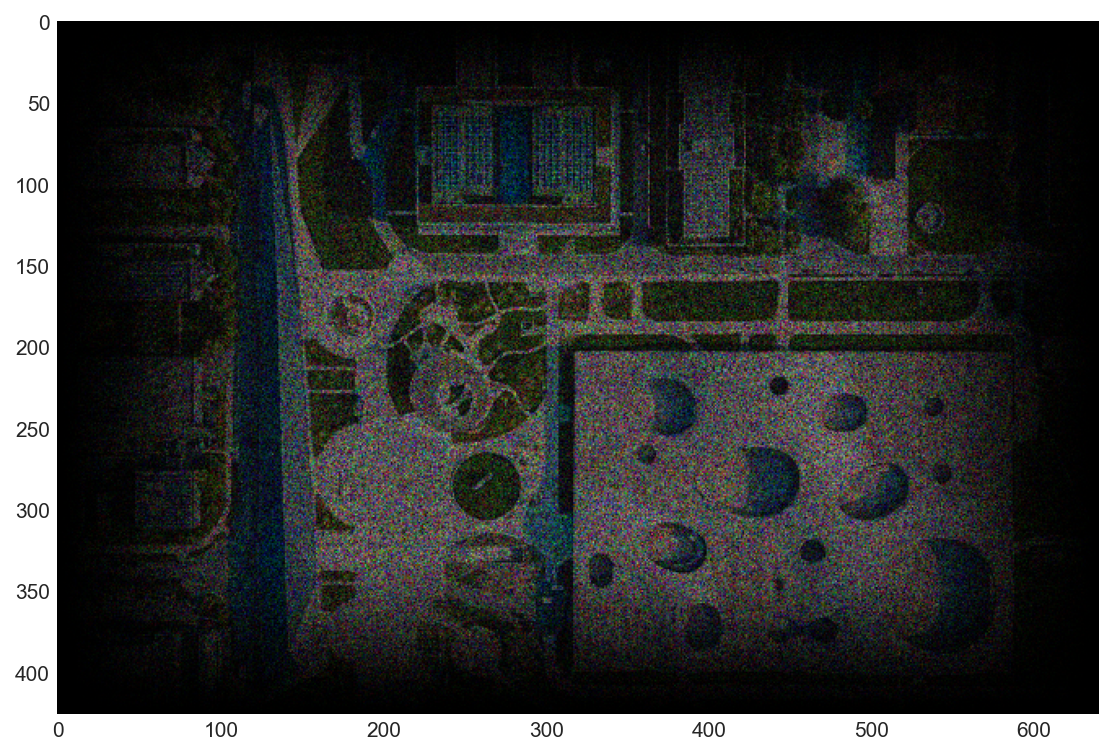

In [7]:
# Pinhole 
gain = 0.4
Gain = pycl.DiagonalOp(gain*np.ones(image.shape[1:]).ravel())
window = np.outer(ss.get_window('tukey', image.shape[1]), ss.get_window('tukey', image.shape[2]))
Window = pycl.DiagonalOp(window.ravel())
Pinhole = Window * Gain
#Pinhole.lipschitz()

# Data
data_pinhole = Pinhole(image.reshape(3, -1)) # Low exposure 
rng = np.random.default_rng()
data_pinhole = np.clip(rng.normal(loc=data_pinhole, scale=np.sqrt(data_pinhole)/4), a_min=0, a_max=1) # shot noise
imshow(data_pinhole.reshape(image.shape), rgb=False)
 

## Pseudo-Inverse Solution

$$ \left[\begin{array}{c}y_L\\y_P\end{array}\right]=\left[\begin{array}{c}L \\ P\end{array}\right]x \Rightarrow \hat{x}=\left[\begin{array}{c}L \\ P\end{array}\right]^\dagger \left[\begin{array}{c}y_L\\y_P\end{array}\right]$$

INFO: [2022-11-24 21:13:47.784274] Iteration 0
	iteration: 0
	AbsError[residual]_min: 135.47849963338209
	AbsError[residual]_max: 138.567462387719
	N_iter: 1.0
INFO: [2022-11-24 21:13:48.527230] Iteration 14
	iteration: 14
	AbsError[residual]_min: 5.742186301128732e-05
	AbsError[residual]_max: 5.93644354104274e-05
	N_iter: 15.0
INFO: [2022-11-24 21:13:48.528034] Stopping Criterion satisfied -> END


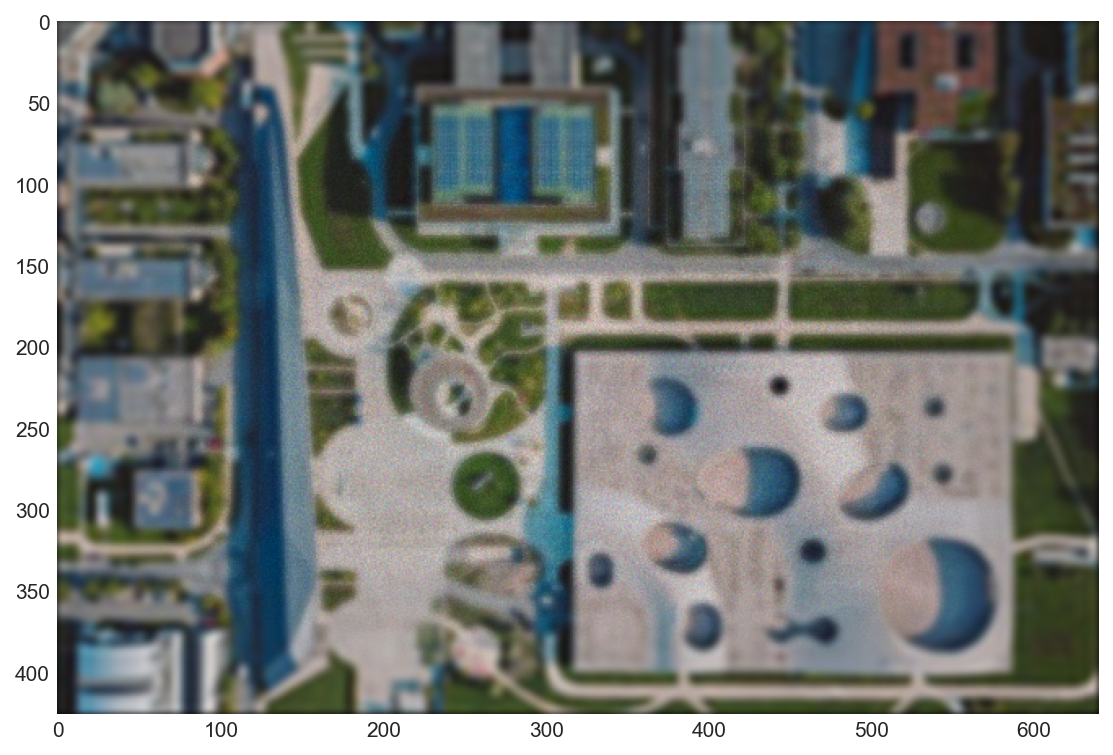

In [9]:
import pycsou.operator.blocks as pycb
import pycsou.opt as pyco

SensingOp = pycb.vstack([0.7*Lens,0.3*Pinhole])
data = np.concatenate([0.7*data_lens,0.3*data_pinhole], axis=-1)
recon = SensingOp.pinv(data, damp=0.1, kwargs_init=dict(show_progress=False, verbosity=1000), kwargs_fit=dict(mode=pyca.Mode.BLOCK))
recon = np.clip(recon, a_min=0, a_max=1)
imshow(recon.reshape(image.shape), rgb=False)

## Bayesian Reconstruction (Range Constraint + isoTV + hybrid Least-squares/Huber Loss)

$$\hat{x}\in \arg\min_x \theta_L\|y_L - L x\|_2^2 + \theta_P\rho_H(y_P- P x) + \lambda\|\nabla x\|_{2,1} + \chi_{[0,1]}(x)$$

In [12]:
import pycsou.operator.linop.diff as pycdiff
import pycsou.operator as pycop
import pycsou.util as pycu
import pycsou.runtime as pycrt
import pycsou.math.linalg as pyclinalg
import numba as nb
import pycsou.opt.solver.pds as pycpds
import pycsou.opt.stop as pycstop


class L21Norm(pyca.ProxFunc):
    def __init__(self, arg_shape, axes=(-2,)):
        super().__init__(shape=(1, np.prod(arg_shape)))
        self._arg_shape = arg_shape
        self._ax = axes
    
    @pycrt.enforce_precision('arr')
    def apply(self, arr):
        x = arr.copy().reshape(arr.shape[:-1] + self._arg_shape)
        return pyclinalg.norm(pyclinalg.norm(x, ord=2, axis=self._ax), ord=1, axis=-1, keepdims=True).reshape(arr.shape[:-1] + (-1,))

    @pycrt.enforce_precision(['arr', 'tau'])
    def prox(self, arr, tau):
        xp = pycu.get_array_module(arr)
        x = arr.copy().reshape(arr.shape[:-1] + self._arg_shape)
        return ((1 - tau/xp.fmax(pyclinalg.norm(x, ord=2, axis=self._ax, keepdims=True), tau)) * x).reshape(arr.shape[:-1] + (-1,))

class Box(pyca.ProxFunc):
    def __init__(self, dim):
        super().__init__(shape=(1, dim))
        
    @pycrt.enforce_precision('arr')
    def apply(self, arr):
        return (0 <= arr) & (arr <= 1)
    
    @pycrt.enforce_precision('arr')
    def prox(self, arr, tau):
        return arr.clip(0, 1)


In [13]:
grad = pycdiff.Gradient.finite_difference(arg_shape=image.shape[1:], accuracy=3, boundary=0.)
grad._lipschitz = 10
box = Box(image[0].size)
lambda_= 0.07
l21 = lambda_ * L21Norm((2, image[0].size))
default_stop_crit = (pycstop.RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) &
                     pycstop.RelError(eps=1e-3, var="z", f=None, norm=2, satisfy_all=True) &
                     pycstop.MaxIter(10)) | pycstop.MaxIter(1000)
est = []
for i in range(3):
    loss_lens = 0.7 * pycop.SquaredL2Norm(dim=data_lens[i].size).argshift(-data_lens[i].ravel()) * Lens
    loss_lens._diff_lipschitz = 0.7*2 * Lens._lipschitz ** 2
    loss_pinhole = 0.3 * pycop.L1Norm(dim=data_pinhole[i].size).moreau_envelope(0.1).argshift(-data_pinhole[i].ravel()) * Pinhole
    loss_pinhole._diff_lipschitz = 0.3*Pinhole._lipschitz ** 2
    loss = loss_lens + loss_pinhole
    loss._diff_lipschitz = loss_lens._diff_lipschitz + loss_pinhole._diff_lipschitz
    solver = pycpds.CondatVu(f=loss, g=box, h=l21, K=grad, show_progress=False, verbosity=250)
    solver.fit(x0=recon[i].reshape(-1), tuning_strategy=2,mode=pyca.Mode.BLOCK, stop_crit=default_stop_crit)
    est.append(solver.solution())

imshow(np.concatenate(est).reshape(image.shape), rgb=False)

ValueError: beta: automatic inference not supported for operators with unbounded Lipschitz gradients.

In [15]:
loss._diff_lipschitz

inf

In [ ]:
grad = pycdiff.Gradient.finite_difference(arg_shape=image.shape[1:], accuracy=3, boundary=0.)
jacobian = pycb.block_diag([grad, grad, grad])
jacobian._lipschitz = 10
box = Box(image.size)
lambda_= 0.07
l21 = lambda_ * L21Norm((3, 2, image[0].size), axes=(-3, -2))
default_stop_crit = (pycstop.RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) &
                     pycstop.RelError(eps=1e-3, var="z", f=None, norm=2, satisfy_all=True) &
                     pycstop.MaxIter(10)) | pycstop.MaxIter(500)
    
loss_lens = 0.7 * pycop.SquaredL2Norm(dim=data_lens.size).argshift(-data_lens.ravel()) * pycb.block_diag([Lens, Lens, Lens])
loss_lens._diff_lipschitz = 0.7 * 2 * Lens._lipschitz ** 2
loss_pinhole = 0.3 * pycop.L1Norm(dim=data_pinhole.size).moreau_envelope(0.1).argshift(-data_pinhole.ravel()) * pycb.block_diag([Pinhole, Pinhole, Pinhole])
loss_pinhole._diff_lipschitz = 0.3* 2 * Pinhole._lipschitz ** 2
loss = loss_lens + loss_pinhole
loss._diff_lipschitz = loss_lens._diff_lipschitz + loss_pinhole._diff_lipschitz
solver = pycpds.CondatVu(f=loss, g=box, h=l21, K=jacobian, show_progress=False, verbosity=250)
solver.fit(x0=recon.reshape(-1), tuning_strategy=2,mode=pyca.Mode.BLOCK, stop_crit=default_stop_crit)
sol = solver.solution()[0]

imshow(sol.reshape(image.shape), rgb=False)

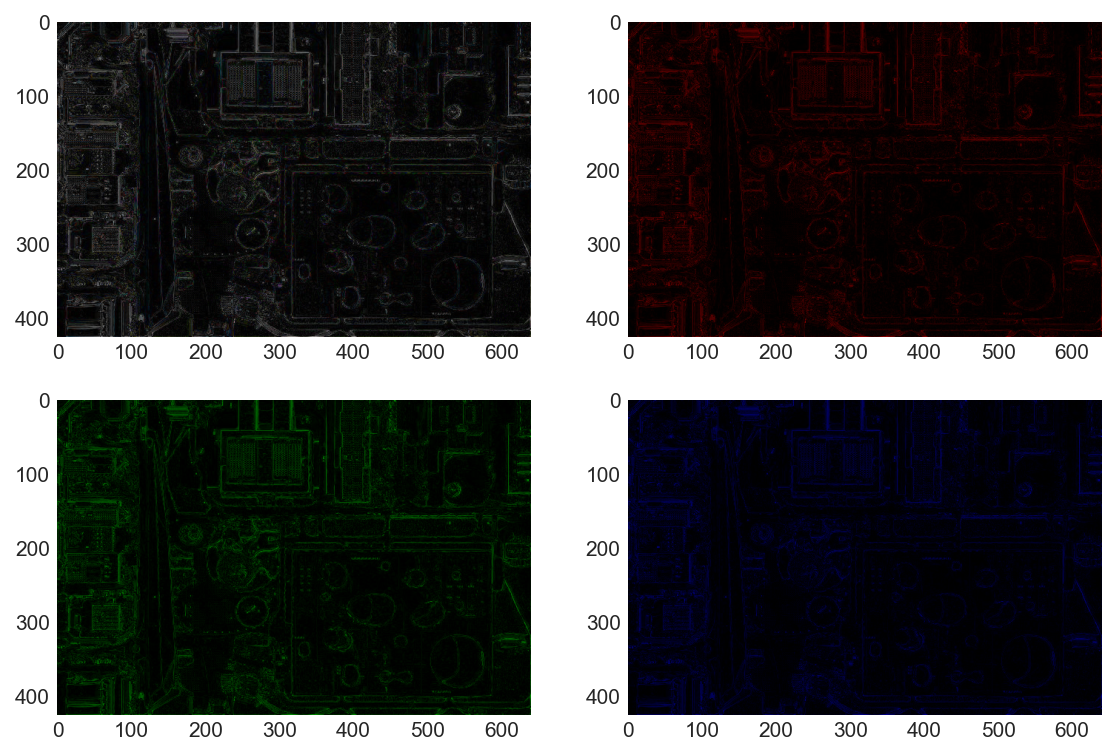

In [123]:
imshow(np.abs(np.concatenate(est).reshape(image.shape)-image))

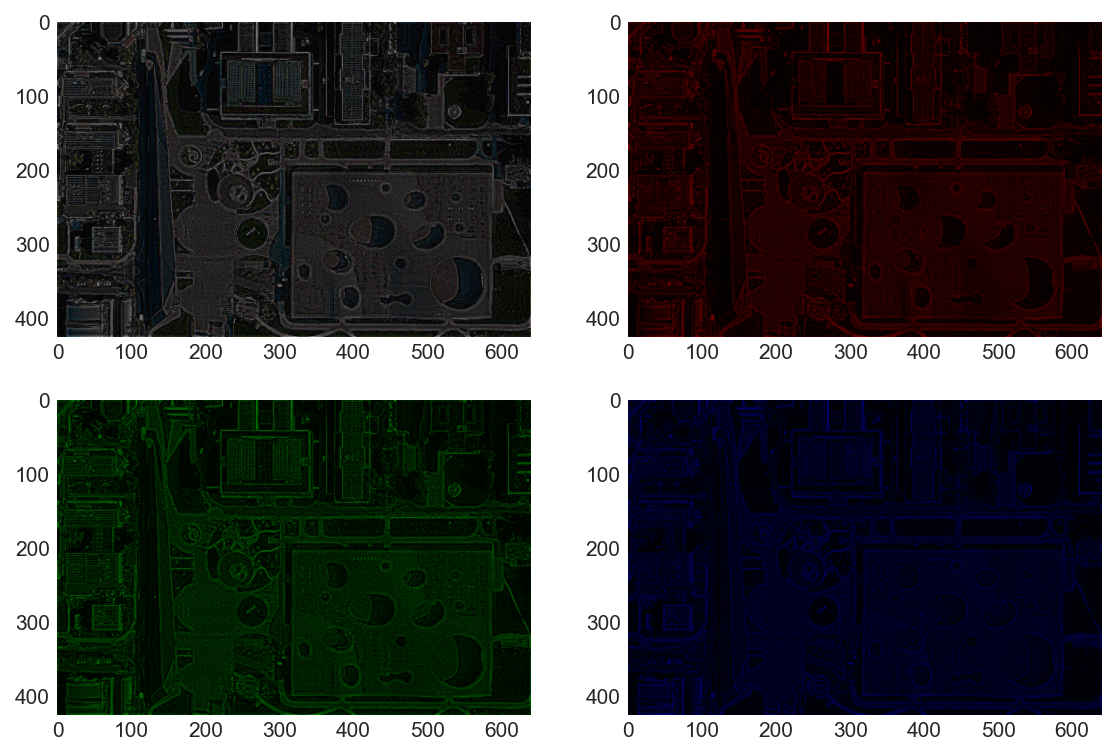

In [125]:
imshow(np.abs(recon.reshape(image.shape)-image))